## Train LeNet-5 CNN Model (TensorFlow)

* Load Dataset

In [2]:
import tensorflow as tf
import numpy as np
import torch

# Load TensorFlow MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize and reshape
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

2024-02-02 11:29:42.328912: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 11:29:42.360313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 11:29:42.360336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 11:29:42.361003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 11:29:42.365618: I tensorflow/core/platform/cpu_feature_guar

* Train

In [15]:
conv1_filters=6
conv2_filters=16
fc1_units=120
fc2_units=84

model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(conv1_filters, kernel_size=(4, 4), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.AvgPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(conv2_filters, kernel_size=(4, 4), activation='relu'),
    tf.keras.layers.AvgPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc1_units),

    tf.keras.layers.Dense(10)
])
    
# Compile the model
model_tf.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

model_tf.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 25, 25, 6)         102       
                                                                 
 average_pooling2d_21 (Aver  (None, 12, 12, 6)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_22 (Conv2D)          (None, 9, 9, 16)          1552      
                                                                 
 average_pooling2d_22 (Aver  (None, 4, 4, 16)          0         
 agePooling2D)                                                   
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 120)             

In [29]:
# Train the model
history = model_tf.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
1688/1688 [==============================] - 3s 1ms/step - loss: 0.8230 - accuracy: 0.7356 - val_loss: 0.2241 - val_accuracy: 0.9308
Epoch 2/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2116 - accuracy: 0.9355 - val_loss: 0.1359 - val_accuracy: 0.9595
Epoch 3/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1367 - accuracy: 0.9579 - val_loss: 0.0967 - val_accuracy: 0.9688
Epoch 4/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1028 - accuracy: 0.9684 - val_loss: 0.0789 - val_accuracy: 0.9770
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0829 - accuracy: 0.9744 - val_loss: 0.0714 - val_accuracy: 0.9788
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0715 - accuracy: 0.9779 - val_loss: 0.0707 - val_accuracy: 0.9772
Epoch 7/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0633 - accuracy: 0.9806 - val_loss: 0.0500 - val_accuracy:

In [30]:
# Evaluate the model
test_loss, test_acc = model_tf.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0444 - accuracy: 0.9863 - 241ms/epoch - 769us/step

Test accuracy: 0.986299991607666


## Convert 2 PyTorch Model

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetPT(nn.Module):
    def __init__(self, conv1_filters, conv2_filters, fc1_units, fc2_units):
        super(LeNetPT, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_filters, 5)
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 5)
        # Calculate the flattened size after convolution and pooling
        self.fc1 = nn.Linear(conv2_filters* 4 * 4, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 10)

    def forward(self, x):
        # Convolutional block
        x = F.avg_pool2d(F.sigmoid(self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d(F.sigmoid(self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool

        batch_size = x.size(0)
        x = x.reshape(x.size(0),x.size(1),-1)  # 16 output channels
        x = np.transpose(x, (0,2,1)).reshape(batch_size,-1)

        # Fully connected layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)  
        return x

# Instantiate the model with specific parameters
model_pt = LeNetPT(conv1_filters, conv2_filters, fc1_units, fc2_units)


In [32]:
# TODO: handle multiple layers

# Transfer weights for the first Conv2D layer from model_tf to model_pt
weights, biases = model_tf.layers[0].get_weights()
model_pt.conv1.weight = nn.Parameter(torch.from_numpy(np.transpose(weights, (3, 2, 0, 1))))
model_pt.conv1.bias = nn.Parameter(torch.from_numpy(biases))

# Transfer weights for the second Conv2D layer from model_tf to model_pt
weights, biases = model_tf.layers[2].get_weights()
model_pt.conv2.weight = nn.Parameter(torch.from_numpy(np.transpose(weights, (3, 2, 0, 1))))
model_pt.conv2.bias = nn.Parameter(torch.from_numpy(biases))

# Transfer weights for the first dense layer (fc1) from model_tf to model_pt
weights, biases = model_tf.layers[5].get_weights()
model_pt.fc1.weight = nn.Parameter(torch.from_numpy(np.transpose(weights, (1, 0))))
model_pt.fc1.bias = nn.Parameter(torch.from_numpy(biases))

# Transfer weights for the second dense layer (fc2) from model_tf to model_pt
weights, biases = model_tf.layers[6].get_weights()
model_pt.fc2.weight = nn.Parameter(torch.from_numpy(np.transpose(weights, (1, 0))))
model_pt.fc2.bias = nn.Parameter(torch.from_numpy(biases))

# Transfer weights for the third dense layer (fc3) from model_tf to model_pt
weights, biases = model_tf.layers[7].get_weights()
model_pt.fc3.weight = nn.Parameter(torch.from_numpy(np.transpose(weights, (1, 0))))
model_pt.fc3.bias = nn.Parameter(torch.from_numpy(biases))

### Controlled Input Testing

In [33]:
# Select the image for TensorFlow
controlled_input_tf = test_images[36][np.newaxis, ]  # No reshape needed as it's already in (28, 28, 1) format
controlled_input_pt = torch.tensor(controlled_input_tf).float().permute(0, 3, 1, 2)

In [34]:
model_pt.eval()  # Set PyTorch model to evaluation mode
with torch.no_grad():
    output_pt = model_pt(controlled_input_pt)

output_tf = model_tf.predict(controlled_input_tf) 
print("TF Basic Model Output:", output_tf)
print("PT Basic Model Output:", output_pt.cpu().numpy())

1/1 [==============================] - 0s 49ms/step
TF Basic Model Output: [[ -3.1242797   -0.2277504    3.8945203   -0.02813251  -7.1591253
   -6.0940948  -11.932893     7.3735785   -2.5715997   -3.0597878 ]]
PT Basic Model Output: [[ -3.124279    -0.22774982   3.8945203   -0.02813319  -7.159124
   -6.0940943  -11.932896     7.3735785   -2.5715997   -3.059788  ]]


### Evaluate Converted Model

In [40]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming the TensorFlow MNIST data has already been loaded
# Convert test_images to PyTorch tensor and permute
test_images_pt = torch.tensor(test_images).permute(0, 3, 1, 2).float()

# Assuming test_labels are already loaded
test_dataset = TensorDataset(test_images_pt, torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model on the test set
accuracy = evaluate_model(model_pt, test_loader)
print(f'Accuracy of the converted model on the test images: {accuracy:.4f}%')

Accuracy of the converted model on the test images: 98.6300%


In [39]:
# Where the original TF model has:
test_loss, test_acc = model_tf.evaluate(test_images, test_labels, verbose=2)
print(f'Accuracy of the original model on the test images: {100 * test_acc:.4f}%')

313/313 - 0s - loss: 0.0444 - accuracy: 0.9863 - 266ms/epoch - 849us/step
Accuracy of the original model on the test images: 98.6300%


## Plot

In [41]:
import matplotlib.pyplot as plt

def plot_mnist_images(dataset, indices = []):

    if not indices:
        fig, axes = plt.subplots(1, len(dataset), figsize=(12, 4))
        
        for i in range(len(axes)):
            image, label = dataset[i]
            ax = axes[i]
            
            image = image.squeeze()  # Remove channel dimension

            ax.imshow(image, cmap='gray')
            ax.set_title(f'Label: {label}')
            ax.axis('off')

        plt.show()
        return

    fig, axes = plt.subplots(1, len(indices), figsize=(12, 4))
    if len(indices) == 1:  # If only one index is provided, wrap axes in a list
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        image = image.squeeze()  # Remove channel dimension

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.show()


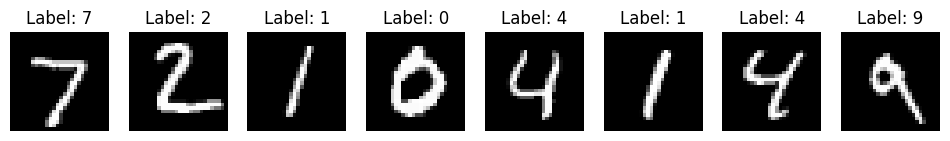

In [42]:
plot_mnist_images(test_dataset, [0,1,2,3,4,5,6,7])

## Save Model

In [43]:
import onnx
from onnx_tf.backend import prepare

folder = '../model/'
# Original Model
model_tf.save(folder + 'model_tf')
model_tf.save(folder + 'model_tf.h5')

# Converted Model
torch.save(model_pt.state_dict(), folder + 'model_pt.pth')
torch.save(model_pt, folder + 'model_pt_full.pth')

INFO:tensorflow:Assets written to: ../model/model_tf/assets


INFO:tensorflow:Assets written to: ../model/model_tf/assets
/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Model

In [ ]:
model_tf = tf.keras.models.load_model(folder + 'model_tf')

# model_tf = tf.keras.models.load_model(folder + 'model_tf.h5')

In [94]:
model_pt = LeNetPT()
model_pt.load_state_dict(torch.load('model_pt.pth'))
model_pt.eval()  # Set the model to evaluation mode

# model_pt = torch.load('model_pt_full.pth')
# model_pt.eval()  # Set the model to evaluation mode

# Compute Accuracy

In [13]:
import ezkl, os, json

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "public"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
# run_args.num_inner_cols = 2
run_args.variables = [("batch_size", 0)]

# Capture set of data points
num_data_points = 8

# Fetch data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(test_loader):
    if i >= num_data_points:
        break
    data_points.append(data_point)


In [14]:
torch.stack(data_points).dim()

5

In [27]:
def gen_witness_LN(folder, model, data_point):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')

    # cal_path = os.path.join(folder, "cal_data.json")
    # srs_path = os.path.join(folder, 'kzg.srs')

    model.eval()
    # Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data_point = data_point.to(device).unsqueeze(0)  # Add a batch dimension
    # _, pred = torch.max(model(data_point),1)
    # train_data_point = train_data_point.to(device)
    # # Export the model to ONNX format
    torch.onnx.export(model, 
                      data_point, 
                      model_path, 
                      export_params=True, 
                      opset_version=10, 
                      do_constant_folding=True, 
                      input_names=['input_0'], 
                      output_names=['output'])

    # Convert the tensor to numpy array and reshape it for JSON serialization
    x = (data_point.cpu().detach().numpy().reshape([-1])).tolist()
    data = dict(input_data = [x])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    # data_points = []
    # for i, (data_point, _) in enumerate(dataset):
    #     if i >= num_data_points:
    #         break
    #     data_points.append(data_point)
        
    # # plot_mnist_images(data_points)

    # # Stack the data points to create a batch
    # train_data_batch = torch.stack(data_points)

    # # Add a batch dimension if not already present
    # if train_data_batch.dim() == 3: # dim == 5
    #     train_data_batch = train_data_batch.unsqueeze(0)

    # x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

    # data = dict(input_data = [x])
    #res = ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources", max_logrows = 12, scales = [2])

    # cal_path = os.path.join('cal_data.json')
    # # Serialize data into file:
    # json.dump( data, open(cal_path, 'w' ))
    os.environ['RUST_LOG'] = 'abc'
    !RUST_LOG=none
    res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
    assert res == True
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources", scales=[2,7])
    assert res == True
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    # srs path
    res = ezkl.get_srs(settings_path)
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    with open(witness_path, "r") as f:
        wit = json.load(f)

    with open(settings_path, "r") as f:
        setting = json.load(f)

    prediction_array = []
    for value in wit["outputs"]:
        for field_element in value:
            prediction_array.append(ezkl.vecu64_to_float(field_element, setting['model_output_scales'][0]))
    return torch.argmax(torch.Tensor([prediction_array]), dim=1)
    #print ('Prediction:', torch.argmax(torch.Tensor([prediction_array]), dim=1) == label.cpu())

In [28]:
def computer_accuracy(folder, model, dataset, size):
    total = 0
    correct = 0

    # folder = "./tmp/"
    # Create the directory 'tmp' in the current working directory
    try:
        os.makedirs(folder, exist_ok=True)
        print(f"Directory '{folder}' created successfully")
    except OSError as error:
        print(f"Directory '{folder}' cannot be created. Error: {error}")

    for image, _ in dataset:
        pred_quantized = gen_witness_LN(folder, model, image)
        outputs = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(outputs, 1)

        total += 1
        correct += (pred == pred_quantized.to(device))

        if total > size:
            break
    
    return 100*correct/total
    #print (f'Test Accuracy: {accuracy:.2f}% (quantized)')

In [29]:
!export RUST_LOG=none
computer_accuracy('./tmp/', model, test_dataset,2)

Directory './tmp/' created successfully


NameError: name 'none' is not defined

In [148]:
acc

tensor([100.], device='cuda:0')

In [33]:
def verify_LN_proof():
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    proof_path = os.path.join(folder, 'proof.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')


    res = ezkl.mock(witness_path, compiled_model_path)
    assert res == True

    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )


    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # Generate the proof
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "single",
        )
    print(proof)
    assert os.path.isfile(proof_path)

    # verify our proof
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
        )

    assert res == True
    print("verified")

In [34]:
verify_LN_proof()

spawning module 2
spawning module 2
spawning module 2
spawning module 2


{'instances': [[[10799958826997019694, 13732764088618192092, 9080164469342476020, 2707268858854354691], [14424721036421401993, 1925070949615222816, 15662063748651391231, 2658040235317113047], [1215616954971237343, 12781145858640582370, 3205897164118176512, 2866280021565530741], [16586418689708852361, 7719159825332846314, 11409209055533372999, 2915207530297009380], [6517656510695314680, 15914426195874827226, 4307566795511864752, 3240703511491837769], [4164547517116989137, 10669376283223625029, 6844937459063939938, 3458232284123655186], [10397520845017782036, 13129438026871282772, 16302847471085186583, 1825458023941667617], [6523463390768162622, 11459244905309910398, 17257037644834070972, 1430799349594821442], [13327914677011761971, 3991458216124611539, 4353392374763218262, 501949994929955151], [11035042354946947612, 2049718776522464053, 8894110146517096806, 3168295732512543866]]], 'proof': '0x0f5a31a4da4bf2e1469d40700f891adc23f25e693e81ef7953871de814f8ef211818e449ce59f0f2f9c60aa8d6d376e